In [1]:
import numpy as np
from scipy.spatial import Delaunay
import matplotlib.pyplot as plt

In [2]:
def generate_mesh(num_points):
    pts = 2 * np.random.random((num_points, 2)) - 1
    tri = Delaunay(pts)
    return pts, tri

def incidence_matrices(nodes, edges, faces):
    num_nodes, num_edges, num_faces = len(nodes), len(edges), len(faces)
    B0 = np.zeros((num_nodes, num_edges), dtype=np.double)
    B1 = np.zeros((num_edges, num_faces), dtype=np.double)

    for i, edge in enumerate(edges):
        v1, v2 = edge
        B0[v1, i] = -1
        B0[v2, i] = 1

    for i, face in enumerate(faces):
        v1, v2, v3 = face
        e1, e2, e3 = (v1, v2), (v1, v3), (v2, v3)
        e1_idx, e2_idx, e3_idx = edges.index(e1), edges.index(e2), edges.index(e3)
        B1[e1_idx, i] = 1
        B1[e2_idx, i] = -1
        B1[e3_idx, i] = 1

    return B0, B1

In [3]:
class SimplicialComplex:
    def __init__(self, points, simplices):
        edge_idx, edges  = {}, {}

        simplices = [x for x in simplices if len(set(x)) == 3] # face has 3 distinct nodes
        simplices = [tuple(sorted(x)) for x in simplices]      # sort node order 

        num_edge = 0
        for face in simplices:
            n1, n2, n3 = face
            face_edges = [(n1, n2), (n1, n3), (n2, n3)]

            for edge in face_edges:
                if edge not in edges:
                    edges[edge] = num_edge
                    edge_idx[num_edge] = edge
                    num_edge += 1

        self.nodes = points
        self.edges = [edge_idx[i] for i in range(num_edge)]
        self.faces = simplices

        self.num_nodes, self.num_edges, self.num_faces = len(points), num_edge, len(simplices)

        self.node_vec = np.ones(self.num_nodes)
        self.edge_vec = np.ones(self.num_edges)
        self.face_vec = np.ones(self.num_faces)

    def add_simplices(self, simplices):
        """
        simplices: dictionary of simplices to be added.
        dictionary keys can be 0, 1, and/or 2
        e.g. simplicies[0] = [1, 3, 4] 
        (set containing 1st, 3rd and 4th node in mesh) 

        Want to add simplices in such a way that simplicial complex structure is 
        maintained. Therefore, if we add a face, we must ensure to add its 
        edges and nodes if they aren't already in the complex.
        """
        simp_dict = {0:set(), 1:set(), 2:set()}
        
        simp_dict[2] = simp_dict[2].union(simplices[2])
        for face in simplices[2]:
            sorted_face = n1, n2, n3 = tuple(sorted(face))
            face_idx = self.faces.index(sorted_face)
            self.face_vec[face_idx] = 1
            e1 = (n1, n2)
            e2 = (n1, n3)
            e3 = (n2, n3)

            nodes_needed = set([n1, n2, n3])
            edges_needed = set([e1, e2, e3])

            simp_dict[0] = simp_dict[0].union(nodes_needed)
            simp_dict[1] = simp_dict[1].union(edges_needed)

        # Add edges
        simp_dict[1].union(simplices[1])
        for edge in simp_dict[1]:
            edge_idx = self.edges.index(edge)
            self.edge_vec[edge_idx] = 1
            n1, n2 = edge

            nodes_needed = set([n1, n2])
            simp_dict[0].union(nodes_needed)
        
        # Add vertices
        simp_dict[0].union(simplices[0])
        for node in simp_dict[0]:
            self.node_vec[node] = 1


    def remove_simplices(self, simplices):
        simp_dict = {0:set(), 1:set(), 2:set()}

        simp_dict[0] = simp_dict[0].union(simplices[0])
        simp_dict[1] = simp_dict[1].union(simplices[1])
        simp_dict[2] = simp_dict[2].union(simplices[2])

        for node in simp_dict[0]:
            self.node_vec[node] = 0

            for edge in self.edges:
                if node in edge:
                    simp_dict[1] = simp_dict[1].union(set([edge]))
                
            for face in self.faces:
                if node in face:
                    simp_dict[2] = simp_dict[2].union(set([face]))


        for edge in simp_dict[1]:
            edge_idx = self.edges.index(tuple(edge))
            self.edge_vec[edge_idx] = 0

            n1, n2 = edge
            for face in self.faces:
                if (n1 in face) and (n2 in face):
                    simp_dict[2] = simp_dict[2].union(set([face]))

            
        for face in simp_dict[2]:
            face_idx = self.faces.index(tuple(face))
            self.face_vec[face_idx] = 0


    def hodge_laplacian(self, k):
        B0, B1 = incidence_matrices(self.nodes, self.edges, self.faces)
        
        for i in range(B0.shape[1]):
            if self.edge_vec[i] == 0:
                B0[:,i] = 0
            
        if k == 0:
            L = B0 @ B0.T
            return L

        else:
            for i in range(B1.shape[1]):
                if self.face_vec[i] == 0:
                    B1[:,i] = 0

            for i in range(B1.shape[0]):
                if self.edge_vec[i] == 0:
                    B1[i,:] = 0

            L = B0.T @ B0 + B1 @ B1.T 

        return L, B0, B1



In [4]:
pts = np.array([[0,2], [2,1], [0,0], [-2,1], [-2,-3], [0,-2], [2,-3]])

tri = Delaunay(pts)

s = SimplicialComplex(pts, tri.simplices)

s
s.edge_vec

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [5]:
s.remove_simplices({0:set(), 1:set([(3,5), (1,5), (1,6)]), 2:set( [ (0,1,2)] ) })
s.edge_vec

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0., 0.])

In [6]:
L, B0, B1 = s.hodge_laplacian(1)
B0

array([[ 0.,  0.,  0., -1., -1.,  0., -1.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.,  1.,  0., -1.,  0.,  0., -1.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  1., -1.,  0.,  0.,  0.,  0.],
       [-1., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.],
       [ 1.,  0., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.],
       [ 0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])

In [7]:
L

array([[ 3.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  0.,  1.,  0.,  0.],
       [ 0.,  3.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  3.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  0.,  0.],
       [ 0.,  0.,  0.,  2.,  1., -1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  3.,  1.,  0.,  0.,  0.,  0., -1.,  0.,  0.],
       [ 0.,  0.,  0., -1.,  1.,  2.,  0., -1.,  0.,  0., -1.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.,  0.,  3.,  0., -1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0., -1.,  0.,  3., -1.,  0.,  1.,  0.,  0.],
       [-1., -1.,  0.,  0.,  0.,  0., -1., -1.,  2.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 1.,  0., -1.,  0., -1., -1.,  0.,  1.,  0.,  0.,  2.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])

In [8]:
w, v = np.linalg.eigh(L)

c = np.array([3, 4, -4, -4, -2, -2, 4, 3, 7, 0, -7, 0 , 0])

edge_labels = s.edges + np.ones((13, 2))

p = np.round(np.linalg.lstsq(B0.T, c, rcond=None)[0].T, 2)
w = np.round(np.linalg.lstsq(B1, c, rcond=None)[0].T, 2)

g = B0.T @ p
r = B1 @ w

h = c - g - r
g.reshape(13,1)

print("RESULTS:")
results = np.hstack([edge_labels, np.vstack([h,g,r]).T, c.reshape(13, 1)])
results

RESULTS:


array([[ 5.  ,  6.  ,  4.72, -0.05, -1.67,  3.  ],
       [ 5.  ,  7.  ,  2.35, -0.02,  1.67,  4.  ],
       [ 6.  ,  7.  , -2.36,  0.03, -1.67, -4.  ],
       [ 1.  ,  2.  , -2.76, -1.24,  0.  , -4.  ],
       [ 1.  ,  3.  , -0.52, -0.48, -1.  , -2.  ],
       [ 2.  ,  3.  , -2.76,  0.76,  0.  , -2.  ],
       [ 1.  ,  4.  ,  3.28, -0.28,  1.  ,  4.  ],
       [ 3.  ,  4.  ,  3.8 ,  0.2 , -1.  ,  3.  ],
       [ 4.  ,  5.  ,  7.08, -0.08,  0.  ,  7.  ],
       [ 4.  ,  6.  ,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 3.  ,  6.  , -7.07,  0.07,  0.  , -7.  ],
       [ 2.  ,  6.  ,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 2.  ,  7.  ,  0.  ,  0.  ,  0.  ,  0.  ]])

In [9]:
nodes = [0,1,2,3,4,5,6]
edges = [(0,1), (0,2), (0,3), (1,2), (2,3), (2,5), (3,4), (4,5), (4,6), (5,6)]
#edges = [(4,5), (4,6), (5,6), (0,1), (0,2), (1,2), (0,3), (2,3), (3,4), (2,5)]
faces = [(0,2,3), (4,5,6)]
#faces = [(4,5,6), (0,2,3)]

B0_2, B1_2 = incidence_matrices(nodes, edges, faces)

L2 = B0_2.T @ B0_2 + B1_2 @ B1_2.T

In [10]:
edge_labels = edges + np.ones((10, 2))

c2 = np.array([-4, -2, 4, -2, 3, -7, 7, 3, 4, -4])

p2 = np.linalg.lstsq(B0_2.T, c2, rcond=None)[0].T
w2 = np.linalg.lstsq(B1_2, c2, rcond=None)[0].T

g2 = B0_2.T @ p2
r2 = B1_2 @ w2

h2 = c2 - g2 - r2

print("RESULTS:")
results = np.hstack([edge_labels, np.vstack([np.round(h2,3),np.round(g2,3),np.round(r2,3)]).T, c2.reshape(10, 1)])
results

RESULTS:


array([[ 1.   ,  2.   , -2.759, -1.241,  0.   , -4.   ],
       [ 1.   ,  3.   , -0.519, -0.481, -1.   , -2.   ],
       [ 1.   ,  4.   ,  3.278, -0.278,  1.   ,  4.   ],
       [ 2.   ,  3.   , -2.759,  0.759,  0.   , -2.   ],
       [ 3.   ,  4.   ,  3.797,  0.203, -1.   ,  3.   ],
       [ 3.   ,  6.   , -7.076,  0.076,  0.   , -7.   ],
       [ 4.   ,  5.   ,  7.076, -0.076,  0.   ,  7.   ],
       [ 5.   ,  6.   ,  4.717, -0.051, -1.667,  3.   ],
       [ 5.   ,  7.   ,  2.359, -0.025,  1.667,  4.   ],
       [ 6.   ,  7.   , -2.359,  0.025, -1.667, -4.   ]])

In [11]:
np.round(L2 @ h2, 10)

array([-0.,  0., -0.,  0., -0., -0.,  0., -0., -0., -0.])

In [12]:
B0_gt = np.zeros((7,10))

B0_gt[0,0] = -1
B0_gt[1,0] = 1

B0_gt[0,1] = -1
B0_gt[2,1] = 1

B0_gt[0,2] = -1
B0_gt[3,2] = 1

B0_gt[1,3] = -1
B0_gt[2,3] = 1

B0_gt[2,4] = -1
B0_gt[3,4] = 1

B0_gt[2,5] = -1
B0_gt[5,5] = 1

B0_gt[3,6] = -1
B0_gt[4,6] = 1

B0_gt[4,7] = -1
B0_gt[5,7] = 1

B0_gt[4,8] = -1
B0_gt[6,8] = 1

B0_gt[5,9] = -1
B0_gt[6,9] = 1

########
# B1
########


B1_gt = np.zeros((10, 2))

B1_gt[1,0] = 1
B1_gt[2,0] = -1
B1_gt[4,0] = 1

B1_gt[7,1] = 1
B1_gt[8,1] = -1
B1_gt[9,1] = 1

L_gt = B0_gt.T @ B0_gt + B1_gt @ B1_gt.T

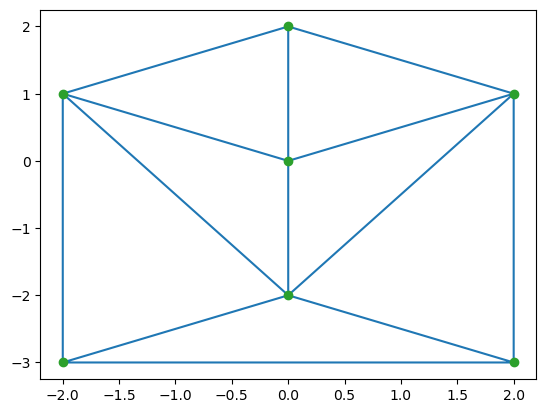

In [13]:
plt.triplot(pts[:,0], pts[:,1], s.faces)
plt.plot(pts[:,0], pts[:,1], 'o')
plt.show()

(0, 1)
(0, 4)
(0, 2)
(0, 5)
(0, 7)


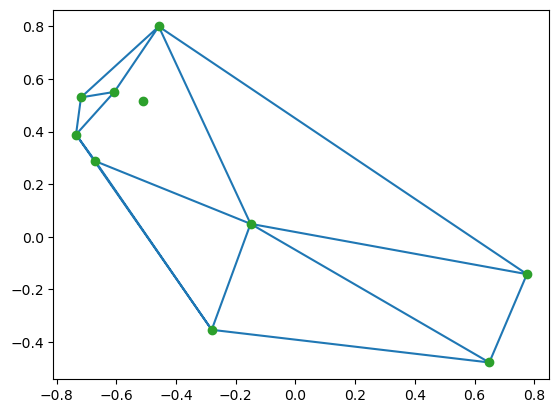

array([1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 0., 1.,
       1., 1., 1., 1.])

In [29]:
points, tri = generate_mesh(10)
a = SimplicialComplex(points, tri.simplices)
a.remove_simplices({0:set([0]), 1:set(), 2:set()})

for edge in a.edges:
    if 0 in edge:
        print(edge)

simplices_on = [x for (i, x) in enumerate(tri.simplices) if a.face_vec[i]]

L, B0, B1 = a.hodge_laplacian(1)

w, v = np.linalg.eigh(L)

plt.triplot(points[:,0], points[:,1], simplices_on)
plt.plot(points[:,0], points[:,1], 'o')
plt.show()

a.edge_vec

In [30]:
w

array([-1.21981562e-16,  2.40588152e-16,  2.68233298e-16,  4.24558016e-16,
        1.12786992e-15,  2.22486789e-15,  1.23139941e+00,  1.26794919e+00,
        1.88986528e+00,  2.00000000e+00,  2.00000000e+00,  3.00000000e+00,
        3.41505777e+00,  4.00000000e+00,  4.00000000e+00,  4.00000000e+00,
        4.47532424e+00,  4.73205081e+00,  4.89926812e+00,  5.77519178e+00,
        6.31389340e+00])

In [211]:
n_edges = a.edge_vec.shape[0]
k = 2
l = 2
ind1 = (a.edge_vec).reshape(n_edges, 1)
ind2 = (1-a.edge_vec).reshape(n_edges, 1)

res1 = v[:,l:l+k] * np.tile(ind1, (1, k))
res1 = np.round(res1, 10)

res2 = v[:,l:l+k] * np.tile(ind2, (1, k))
res2 = np.round(res2, 10)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1.])

In [212]:
np.round(res2 / np.linalg.norm(res1, axis=0), 3)

array([[  0.   ,   0.   ],
       [  0.   ,  -0.   ],
       [  0.   ,  -0.   ],
       [ 99.123,  16.367],
       [ -9.396,   6.032],
       [ -0.   ,   0.   ],
       [ -0.   ,   0.   ],
       [ 76.214, -34.119],
       [ 36.693,   0.164],
       [ -0.   ,   0.   ],
       [ 37.67 ,  27.337],
       [ -0.   ,   0.   ],
       [  0.   ,   0.   ],
       [  0.   ,  -0.   ],
       [  0.   ,  -0.   ],
       [ -0.537,   0.207],
       [  0.   ,  -0.   ],
       [  0.   ,  -0.   ],
       [ -0.   ,   0.   ],
       [ -0.   ,   0.   ],
       [  0.   ,  -0.   ]])

In [217]:
np.round(res1 / np.linalg.norm(res1, axis=0), 3)

array([[ 0.   ,  0.   ],
       [ 0.289, -0.289],
       [ 0.289, -0.289],
       [ 0.   ,  0.   ],
       [-0.   ,  0.   ],
       [-0.289,  0.289],
       [-0.289,  0.289],
       [ 0.   , -0.   ],
       [ 0.   ,  0.   ],
       [-0.289,  0.289],
       [ 0.   ,  0.   ],
       [-0.289,  0.289],
       [ 0.   ,  0.   ],
       [ 0.289, -0.289],
       [ 0.289, -0.289],
       [-0.   ,  0.   ],
       [ 0.289, -0.289],
       [ 0.289, -0.289],
       [-0.   ,  0.   ],
       [-0.289,  0.289],
       [ 0.289, -0.289]])

In [149]:
w

array([-2.30687180e-15, -9.26171212e-16, -1.19417711e-16, -1.08548492e-17,
        5.36233982e-16,  8.87561547e-16,  9.64963771e-16,  1.26794919e+00,
        1.26794919e+00,  2.00000000e+00,  2.00000000e+00,  2.00000000e+00,
        4.00000000e+00,  4.00000000e+00,  4.00000000e+00,  4.00000000e+00,
        4.00000000e+00,  4.00000000e+00,  4.73205081e+00,  4.73205081e+00,
        6.00000000e+00])